# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.morphology import skeletonize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import tensorflow as tf
import networkx as nx
from extra_keras_datasets import usps

# Datasets

In [2]:
datasets = {
    "mnist": {"dataloader": tf.keras.datasets.mnist.load_data, "edge_detection": False, "scale": False},
    "fashion_mnist": {"dataloader": tf.keras.datasets.fashion_mnist.load_data, "edge_detection": True, "scale": False},
    "usps": {"dataloader": usps.load_data, "edge_detection": False, "scale": True},
}

In [3]:
current_dataset = datasets["usps"]

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Load  dataset
(x_train, y_train), (x_test, y_test) = current_dataset["dataloader"]()

INFO:root:Loading dataset = usps


In [6]:
images_train = x_train
images_test = x_test

In [7]:
k = 0

### Viewing an image

In [8]:
def show_image(image):
  plt.figure(figsize=(2, 2))
  plt.imshow(image, interpolation='nearest', cmap='gray')
  plt.show()

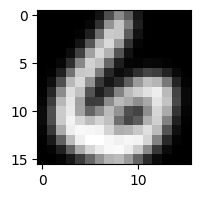

In [9]:
show_image(images_train[k])

# Preprocessing Images

In [10]:
def scale(images):
  return ((images + 1) / 2.0) * 255.0

In [11]:
if current_dataset["scale"]:
  images_train = scale(images_train)
  images_test = scale(images_test)

In [12]:
def convert_edgedetection(images):
    edge_detection = []
    for image in images:
        if image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        
        # Apply Gaussian blur to reduce noise and smoothen edges 
        blurred = cv2.GaussianBlur(src=image, ksize=(3, 3), sigmaX=1, sigmaY=1) 
      
        # Perform Canny edge detection 
        edges = cv2.Canny(blurred, 225, 250)
        edge_detection.append(edges)
    return edge_detection

In [13]:
if current_dataset["edge_detection"]:
  edge_detection_train = convert_edgedetection(images_train)
  edge_detection_test = convert_edgedetection(images_test)
  images_train = edge_detection_train
  images_test = edge_detection_test

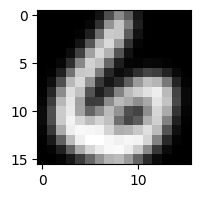

In [14]:
show_image(images_train[k])

In [15]:
def get_threshold(image):
  count = 0
  sum = 0
  med = np.median(image)
  for row in image:
    for x in row:
      if x != 0 and x >= med:
        sum += x
        count += 1
  
  return int(sum / count)

In [16]:
get_threshold(images_train[k])

160

In [17]:
def convert_binary(images):
    binary_images = []
    for image in images:
        _, thresholded = cv2.threshold(image, max(get_threshold(image) - 1, 0), 255, cv2.THRESH_BINARY)
        binary_images.append(thresholded)
    return binary_images

In [18]:
binary_images_train = convert_binary(images_train)
binary_images_test = convert_binary(images_test)

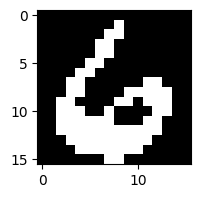

In [19]:
show_image(binary_images_train[k])

In [20]:
def convert_skeletonize(binary_images):
    skeletonized_images = []
    for binary_image in binary_images:
        skeletonized_image = skeletonize(binary_image)
        skeletonized_images.append(skeletonized_image.astype(np.uint8))
    return skeletonized_images

In [21]:
skeletonized_images_train = convert_skeletonize(binary_images_train)
skeletonized_images_test = convert_skeletonize(binary_images_test)

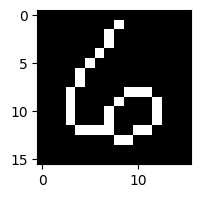

In [22]:
show_image(skeletonized_images_train[k])

# Creating Graph

In [23]:
def create_nodes(skeletonized_images):
    nodes_list = []
    node_features_list = []
    for skeletonized_image in skeletonized_images:
        nodes = []
        features = []
        for i in range(skeletonized_image.shape[0]):
            for j in range(skeletonized_image.shape[1]):
                if skeletonized_image[i, j] == 1:
                    nodes.append((i, j))
                    features.append([i, j])
        nodes_list.append(nodes)
        node_features_list.append(features)
    return nodes_list, node_features_list

In [24]:
nodes_list_train, node_features_list_train = create_nodes(skeletonized_images_train)
nodes_list_test, node_features_list_test = create_nodes(skeletonized_images_test)

In [25]:
nodes_list_train[k][:5]

[(1, 8), (2, 7), (3, 7), (4, 6), (5, 5)]

In [26]:
node_features_list_train[k][:5]

[[1, 8], [2, 7], [3, 7], [4, 6], [5, 5]]

In [27]:
def create_graph(nodes_list, skeletonized_images):
    graphs = []
    for nodes, image in zip(nodes_list, skeletonized_images):
        # Create a graph
        G = nx.Graph()

        # Add nodes for white pixels
        G.add_nodes_from(nodes)
        for i, j in nodes:
            for x in range(-1, 2):
                for y in range(-1, 2):
                    if 0 <= i + x < image.shape[0] and 0 <= j + y < image.shape[1] and (x != 0 or y != 0) and image[i + x, j + y] == 1:
                        G.add_edge((i, j), (i + x, j + y))
        graphs.append(G)
    return graphs

In [28]:
graphs_train = create_graph(nodes_list_train, skeletonized_images_train)
graphs_test = create_graph(nodes_list_test, skeletonized_images_test)

In [29]:
nodes_dict_train = [{value: index for index, value in enumerate(list)} for list in nodes_list_train]
nodes_dict_test = [{value: index for index, value in enumerate(list)} for list in nodes_list_test]

In [30]:
nodes_dict_train[k]

{(1, 8): 0,
 (2, 7): 1,
 (3, 7): 2,
 (4, 6): 3,
 (5, 5): 4,
 (6, 4): 5,
 (7, 4): 6,
 (8, 3): 7,
 (8, 9): 8,
 (8, 10): 9,
 (8, 11): 10,
 (9, 3): 11,
 (9, 8): 12,
 (9, 12): 13,
 (10, 3): 14,
 (10, 7): 15,
 (10, 12): 16,
 (11, 3): 17,
 (11, 7): 18,
 (11, 12): 19,
 (12, 4): 20,
 (12, 5): 21,
 (12, 6): 22,
 (12, 7): 23,
 (12, 10): 24,
 (12, 11): 25,
 (13, 8): 26,
 (13, 9): 27}

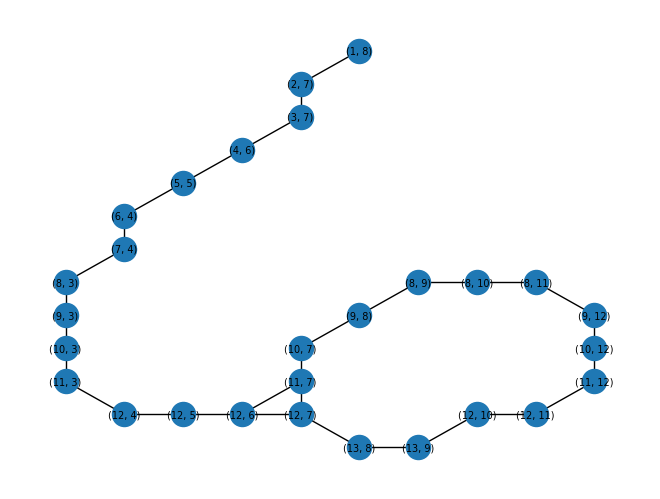

In [31]:
pos = {(i, j): (j, -i) for i, j in graphs_train[k].nodes()}
nx.draw(graphs_train[k], pos, with_labels=True, font_size=7)
plt.show()

In [32]:
def create_edge_index(graph, nodes_dict):
    edges = []
    edge_from = []
    edge_to = []
    for (i, j) in graph.edges():
        edge_from.append(nodes_dict[i])
        edge_to.append(nodes_dict[j])
    edges.append(edge_from)
    edges.append(edge_to)
    return np.array(edges)


In [33]:
graphs_train[k].edges()

EdgeView([((1, 8), (2, 7)), ((2, 7), (3, 7)), ((3, 7), (4, 6)), ((4, 6), (5, 5)), ((5, 5), (6, 4)), ((6, 4), (7, 4)), ((7, 4), (8, 3)), ((8, 3), (9, 3)), ((8, 9), (8, 10)), ((8, 9), (9, 8)), ((8, 10), (8, 11)), ((8, 11), (9, 12)), ((9, 3), (10, 3)), ((9, 8), (10, 7)), ((9, 12), (10, 12)), ((10, 3), (11, 3)), ((10, 7), (11, 7)), ((10, 12), (11, 12)), ((11, 3), (12, 4)), ((11, 7), (12, 6)), ((11, 7), (12, 7)), ((11, 12), (12, 11)), ((12, 4), (12, 5)), ((12, 5), (12, 6)), ((12, 6), (12, 7)), ((12, 7), (13, 8)), ((12, 10), (12, 11)), ((12, 10), (13, 9)), ((13, 8), (13, 9))])

In [34]:
edges_index_list_train = [create_edge_index(graphs_train[i], nodes_dict_train[i]) for i in range(len(images_train))]
edges_index_list_test = [create_edge_index(graphs_test[i], nodes_dict_test[i]) for i in range(len(images_test))]

In [35]:
edges_index_list_train[k]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  8,  9, 10, 11, 12, 13, 14,
        15, 16, 17, 18, 18, 19, 20, 21, 22, 23, 24, 24, 26],
       [ 1,  2,  3,  4,  5,  6,  7, 11,  9, 12, 10, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 23, 25, 21, 22, 23, 26, 25, 27, 27]])

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

# Making Dataset

In [37]:
class CustomGraphDataset(Dataset):
    def __init__(self, data_list):
        super(CustomGraphDataset, self).__init__()
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

    # Additional abstract methods to implement
    def get(self, idx):
        # Implement logic to retrieve data at the given index
        return self.data_list[idx]

    def len(self):
        # Implement logic to return the length of the dataset
        return len(self.data_list)

In [38]:
def create_custom_data_instance(node_features, edges, label):
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long)
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

In [39]:
data_list_train = [create_custom_data_instance(node_features_list_train[i], edges_index_list_train[i], y_train[i]) for i in range(len(images_train))]
custom_dataset_train = CustomGraphDataset(data_list_train)

data_list_test = [create_custom_data_instance(node_features_list_test[i], edges_index_list_test[i], y_test[i]) for i in range(len(images_test))]
custom_dataset_test = CustomGraphDataset(data_list_test)

In [40]:
num_features = custom_dataset_train.num_features
num_classes = custom_dataset_train.num_classes

In [41]:
train_dataset, val_dataset = train_test_split(custom_dataset_train, test_size=0.2, random_state=42)
test_dataset = custom_dataset_test

In [42]:
# Use PyTorch DataLoader to handle batching
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [43]:
len(train_dataset)

5832

In [44]:
test_dataset

CustomGraphDataset(2007)

In [45]:
train_dataset[k]

Data(x=[30, 2], edge_index=[2, 33], y=[1])

In [46]:
print(f'Number of Features: {num_features}, Number of Classes: {num_classes}')

Number of Features: 2, Number of Classes: 10


Graph Neural Network for Graph Classification

In [47]:
class GCNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNClassifier, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim[0])
        self.conv2 = GraphConv(hidden_dim[0], hidden_dim[1])
        self.conv3 = GraphConv(hidden_dim[1], hidden_dim[2])
        self.conv4 = GraphConv(hidden_dim[2], output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        # x = F.dropout(x, p=0.2)
        x = F.relu(self.conv2(x, edge_index))
        # x = F.dropout(x, p=0.2)
        x = F.relu(self.conv3(x, edge_index))
        # x = F.dropout(x, p=0.2)
        x = F.relu(self.conv4(x, edge_index))
        # x = F.dropout(x, p=0.2)
        x = global_mean_pool(x, batch)
        # x = global_add_pool(x, batch)
        return F.log_softmax(x, dim=1)

In [48]:
# Instantiate the Graph Neural Network model
input_dim = num_features
hidden_dim = [32, 16, 16]
output_dim = num_classes
gcnClassifier = GCNClassifier(input_dim, hidden_dim, output_dim)

# Define the optimizer
optimizer = torch.optim.Adam(gcnClassifier.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [49]:
# Training loop
num_epochs = 100  # Increase the number of epochs
patience = 10  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    gcnClassifier.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = gcnClassifier(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

    # Validation
    gcnClassifier.eval()
    val_loss = 0
    for data in val_loader:
        output = gcnClassifier(data)
        val_loss += criterion(output, data.y).item()
    val_loss /= len(val_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping! at Epoch: {epoch + 1}')
            break

Epoch 1/100, Loss: 0.8024153709411621, Validation Loss: 0.7367369701033053
Epoch 2/100, Loss: 0.6022447943687439, Validation Loss: 0.6183513085479322
Epoch 3/100, Loss: 0.09150639921426773, Validation Loss: 0.5564723205955132
Epoch 4/100, Loss: 0.6323089003562927, Validation Loss: 0.4867845900032831
Epoch 5/100, Loss: 0.3852585256099701, Validation Loss: 0.47072042978328205
Epoch 6/100, Loss: 0.24733474850654602, Validation Loss: 0.4297575761118661
Epoch 7/100, Loss: 0.07592655718326569, Validation Loss: 0.4684043285315451
Epoch 8/100, Loss: 1.0108888149261475, Validation Loss: 0.42663342278936633
Epoch 9/100, Loss: 0.2679463028907776, Validation Loss: 0.4581036156286364
Epoch 10/100, Loss: 0.7414358258247375, Validation Loss: 0.3996303826570511
Epoch 11/100, Loss: 0.09228310734033585, Validation Loss: 0.4229593034023824
Epoch 12/100, Loss: 0.2772780954837799, Validation Loss: 0.3561469570774099
Epoch 13/100, Loss: 0.9966683983802795, Validation Loss: 0.3348712772130966
Epoch 14/100, L

In [54]:
# Evaluation
gcnClassifier.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        output = gcnClassifier(data)
        _, predicted = torch.max(output, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

        # Collect predictions and ground truth for later metric calculation
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

# Print classification report
print("Classification Report:\n", classification_report(all_labels, all_predicted, zero_division=1, digits=4))

Classification Report:
               precision    recall  f1-score   support

           0     0.9797    0.9387    0.9587       359
           1     0.9296    0.9508    0.9401       264
           2     0.9137    0.9091    0.9114       198
           3     0.8861    0.8434    0.8642       166
           4     0.9211    0.8750    0.8974       200
           5     0.8547    0.9187    0.8855       160
           6     0.9176    0.9176    0.9176       170
           7     0.9556    0.8776    0.9149       147
           8     0.7089    0.9096    0.7968       166
           9     0.8797    0.7853    0.8299       177

    accuracy                         0.8994      2007
   macro avg     0.8947    0.8926    0.8917      2007
weighted avg     0.9048    0.8994    0.9004      2007



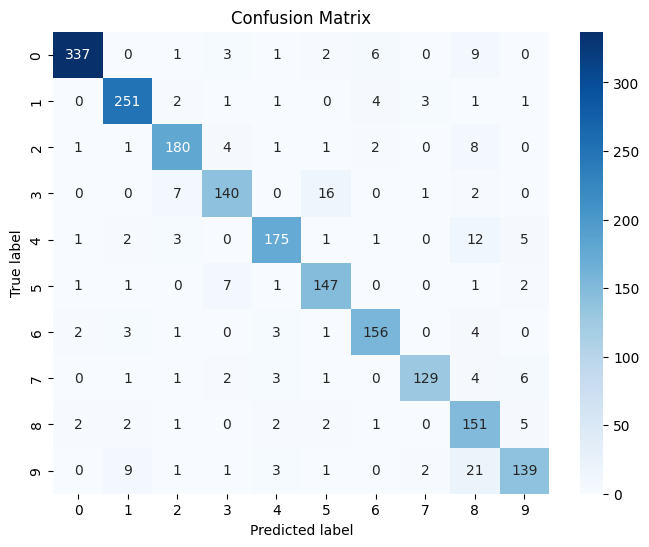

In [55]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()